In [3]:
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from matplotlib.ticker import MaxNLocator
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load the data
df_city_time_series = pd.read_csv('train_city_csv.csv',parse_dates=['Date'])
# drop null values in ZHVIPerSqft_AllHomes
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])
df_city_time_series.head()

Date              RegionName  InventorySeasonallyAdjusted_AllHomes  \
0 2003-01-31    abbevillelafayettems                                   NaN   
1 2003-01-31      abbottstownadamspa                                   NaN   
2 2003-01-31       aberdeenbinghamid                                   NaN   
3 2003-01-31  aberdeengrays_harborwa                                   NaN   
4 2003-01-31       aberdeenharfordmd                                   NaN   

   InventoryRaw_AllHomes  MedianListingPricePerSqft_1Bedroom  \
0                    NaN                                 NaN   
1                    NaN                                 NaN   
2                    NaN                                 NaN   
3                    NaN                                 NaN   
4                    NaN                                 NaN   

   MedianListingPricePerSqft_2Bedroom  MedianListingPricePerSqft_3Bedroom  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

   MedianListingPricePerSqft_4Bedroom  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

   MedianListingPricePerSqft_5BedroomOrMore  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   MedianListingPricePerSqft_AllHomes     ...       Unnamed: 66  Unnamed: 67  \
0                                 NaN     ...               NaN          NaN   
1                                 NaN     ...               NaN          NaN   
2                                 NaN     ...               NaN          NaN   
3                                 NaN     ...               NaN          NaN   
4                                 NaN     ...               NaN          NaN   

   Unnamed: 68  Unnamed: 69  Unnamed: 70  Unnamed: 71  Unnamed: 72  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 73  Unnamed: 74  Unnamed: 75  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN  

[5 rows x 76 columns]

In [3]:
# Grouping the data datewise on the column date
df_zhvi_sqft_all = df_city_time_series.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all').ZHVIPerSqft_AllHomes

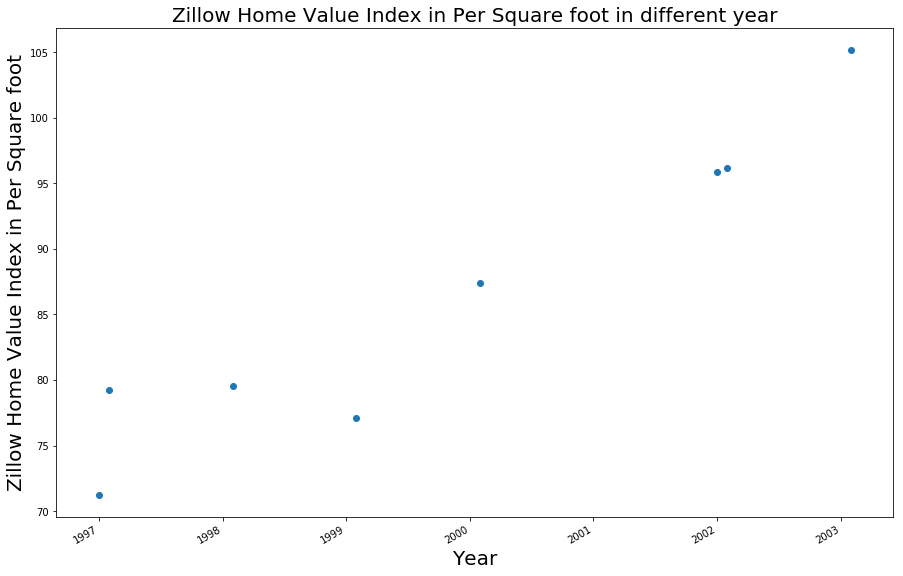

In [4]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.scatter(df_zhvi_sqft_all.index, df_zhvi_sqft_all)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# title to the graph
plt.title('Zillow Home Value Index in Per Square foot in different year', fontsize = 20)
# add xlabel
plt.xlabel('Year', fontsize = 20)
# add ylabel
plt.ylabel('Zillow Home Value Index in Per Square foot', fontsize = 20)
fig.autofmt_xdate()
plt.show()

In [5]:
# frame a sequence as a supervised learning problem
# this methods will create a column and column value will be 1 shift from the data. 
# it will make our data to supervised so that we can feed into network
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [6]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [7]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [8]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [9]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [10]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [11]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [12]:
# convert our column to pandas series 
series = pd.Series(df_zhvi_sqft_all)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(raw_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [13]:
# repeat 30 times
repeats = 30
# variable for keep track of error scores
acc_scores = list()
error_scores_rmse = list()
error_scores_mse = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 50, 15)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = m.sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    # print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores_rmse.append(rmse)
    mse = mean_squared_error(raw_values[train_size:len(supervised_values)], predictions)
    # print('%d) Test MSE: %.3f' % (r+1, mse))
    error_scores_mse.append(mse)
    avg_rmse = mean(error_scores_rmse)
    avg_mse = mean(error_scores_mse)

1) Test RMSE: 77.591
1) Test MSE: 6020.333
2) Test RMSE: 77.688
2) Test MSE: 6035.378
3) Test RMSE: 78.629
3) Test MSE: 6182.511
4) Test RMSE: 76.996
4) Test MSE: 5928.330
5) Test RMSE: 76.424
5) Test MSE: 5840.670
6) Test RMSE: 77.955
6) Test MSE: 6077.041
7) Test RMSE: 76.973
7) Test MSE: 5924.799
8) Test RMSE: 77.741
8) Test MSE: 6043.673
9) Test RMSE: 77.187
9) Test MSE: 5957.760
10) Test RMSE: 76.679
10) Test MSE: 5879.631
11) Test RMSE: 78.607
11) Test MSE: 6179.088
12) Test RMSE: 77.517
12) Test MSE: 6008.954
13) Test RMSE: 77.819
13) Test MSE: 6055.754
14) Test RMSE: 77.653
14) Test MSE: 6030.015
15) Test RMSE: 77.578
15) Test MSE: 6018.325
16) Test RMSE: 77.881
16) Test MSE: 6065.522
17) Test RMSE: 76.728
17) Test MSE: 5887.147
18) Test RMSE: 78.175
18) Test MSE: 6111.382
19) Test RMSE: 77.078
19) Test MSE: 5940.977
20) Test RMSE: 77.699
20) Test MSE: 6037.105
21) Test RMSE: 77.965
21) Test MSE: 6078.524
22) Test RMSE: 76.947
22) Test MSE: 5920.915
23) Test RMSE: 78.858
23) Te

In [4]:
#Load the data
State_time_series=pd.read_csv("State_time_series.csv",parse_dates=True)
State_time_series.Date=pd.to_datetime(State_time_series.Date)
State_time_series['year'] = State_time_series.Date.dt.year

In [15]:
states = set(State_time_series[~State_time_series['ZHVI_AllHomes'].isnull() & ~State_time_series['Sale_Prices'].isnull()]['RegionName'].values)

State_time_series_year = State_time_series[State_time_series['RegionName'].isin(states)].copy()
highest_cost_states = State_time_series_year[['RegionName', 'ZHVI_AllHomes']].groupby('RegionName').max().sort_values(by=['ZHVI_AllHomes'], ascending=False)[:5].index.values.tolist()
State_time_series_year=State_time_series_year[State_time_series_year.RegionName.isin(highest_cost_states)]
State_time_series_year.year = State_time_series_year.Date.dt.year

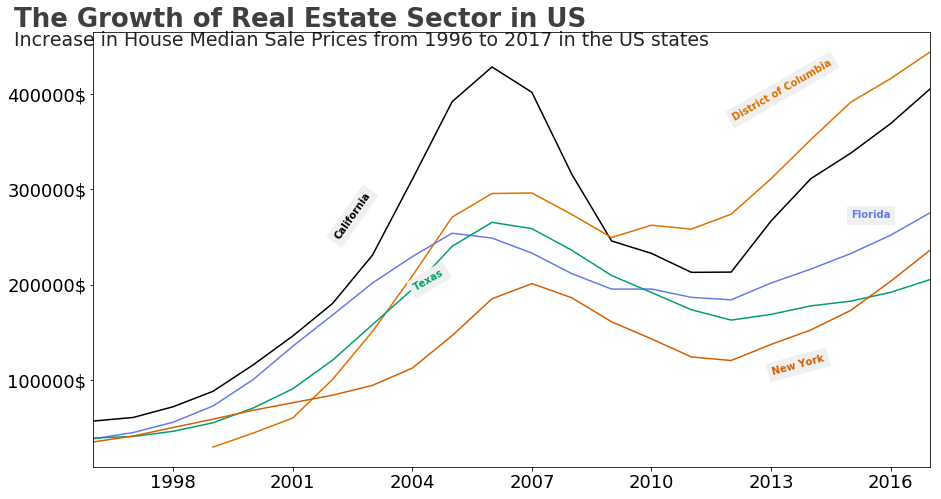

In [132]:
colors = [[0,0,0], [223/255,112/255,0], [100/255,123/255,233/255], [0,158/255,115/255], [213/255,94/255,0], [0,114/255,178/255]]


States_year_SalePrices = State_time_series_year.groupby([State_time_series_year.year,State_time_series_year.RegionName])['ZHVI_AllHomes'].mean().dropna().reset_index(name='SoldPrice')
fte_graph = States_year_SalePrices.pivot(index='year', columns='RegionName', values='SoldPrice').plot(figsize=(15,8), color=colors, legend=False)
fte_graph.figure.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.xlabel("")
fte_graph.set_yticklabels(labels = [-10, '100000$', '200000$', '300000$', '400000$', '500000$'])
# Add an extra vertical line by tweaking the range of the x-axis
fte_graph.set_xlim(left = 1996, right = 2017)
# Adding a title and a subtitle
fte_graph.text(x = 1994, y = 570000, s = "The Growth of Real Estate Sector in US",
               fontsize = 26, weight = 'bold', alpha = .75)
fte_graph.text(x = 1994, y = 550000, 
               s = 'Increase in House Median Sale Prices from 1996 to 2017 in the US states',
              fontsize = 19, alpha = .85)

# Add colored labels
fte_graph.text(x = 2002, y = 390000, s = 'California', color = colors[0], weight = 'bold', rotation = 55,
              backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2012, y = 530000, s = 'District of Columbia', color = colors[1], weight = 'bold', rotation = 30,
              backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2015, y = 370000, s = 'Florida', color = colors[2], weight = 'bold', rotation = 0, 
               backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2004, y = 310000, s = 'Texas', color = colors[3], weight = 'bold', rotation = 30,
              backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2013, y = 220000, s = 'New York', color = colors[4], weight = 'bold',  rotation = 15,
              backgroundcolor = '#f0f0f0');

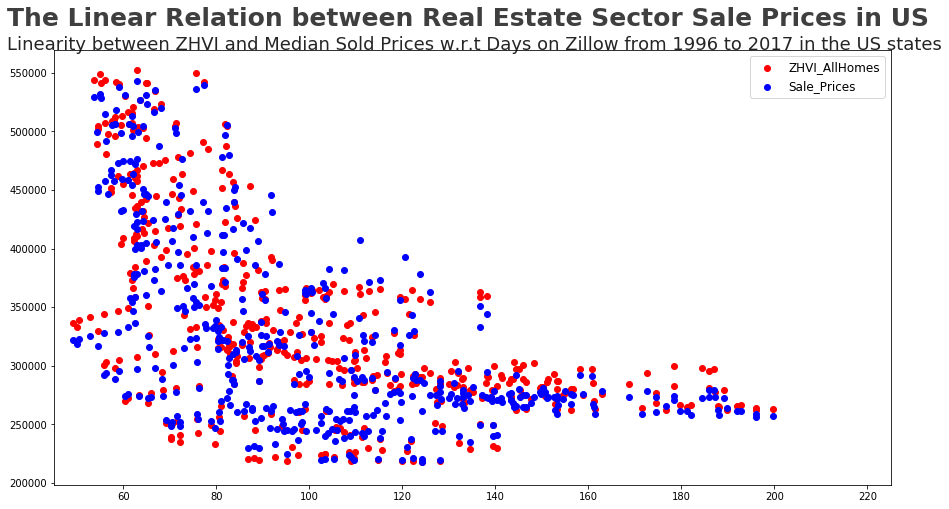

In [134]:
plt.figure(figsize=(15,8));
plt.scatter(State_time_series_year.DaysOnZillow_AllHomes,State_time_series_year.ZHVI_AllHomes,c="red");
plt.scatter(State_time_series_year.DaysOnZillow_AllHomes,State_time_series_year.Sale_Prices,c="blue");

# Add an extra vertical line by tweaking the range of the x-axis
plt.xlim(left = 45, right = 225)
plt.legend(fontsize=12,loc='best',frameon=1,fancybox=1)
# Adding a title and a subtitle
plt.text(x = 35, y = 590000, s = "The Linear Relation between Real Estate Sector Sale Prices in US",
               fontsize = 25, weight = 'bold', alpha = .75)
plt.text(x = 35, y = 570000, 
               s = 'Linearity between ZHVI and Median Sold Prices w.r.t Days on Zillow from 1996 to 2017 in the US states',
              fontsize = 18, alpha = .85);


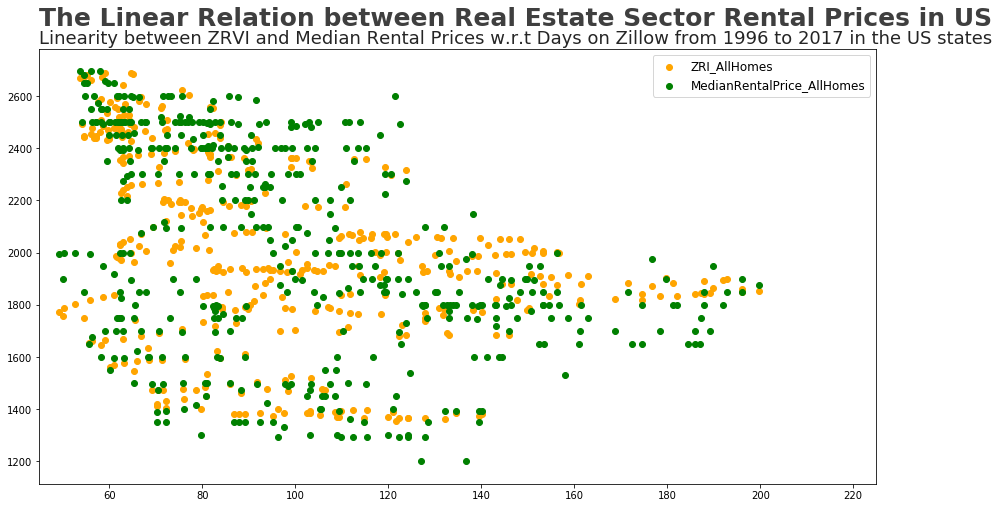

In [135]:
plt.figure(figsize=(15,8));
plt.scatter(State_time_series_year.DaysOnZillow_AllHomes,State_time_series_year.ZRI_AllHomes,c="orange")
plt.scatter(State_time_series_year.DaysOnZillow_AllHomes,State_time_series_year.MedianRentalPrice_AllHomes,c="green");

# Add an extra vertical line by tweaking the range of the x-axis
plt.xlim(left = 45, right = 225)
plt.legend(fontsize=12,loc='best',frameon=1,fancybox=1)
# Adding a title and a subtitle
plt.text(x = 45, y = 2870, s = "The Linear Relation between Real Estate Sector Rental Prices in US",
               fontsize = 25, weight = 'bold', alpha = .75)
plt.text(x = 45, y = 2800, 
               s = 'Linearity between ZRVI and Median Rental Prices w.r.t Days on Zillow from 1996 to 2017 in the US states',
              fontsize = 18, alpha = .85);

In [19]:
StateDF=State_time_series_year[['Date','ZHVI_AllHomes']]
StateDF.dropna(inplace=True)
#prophet expects data in the format as DF('ds','y)
StateDF['ds']=StateDF['Date']
StateDF['y']=np.log(StateDF['ZHVI_AllHomes'])
del StateDF['Date']
del StateDF['ZHVI_AllHomes']
StateDF.head()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

ds          y
3  1996-04-30  11.969717
19 1996-04-30  11.829924
27 1996-04-30  11.851538
41 1996-04-30  11.808576
47 1996-05-31  11.969084

In [27]:
train=StateDF[:len(StateDF)-40]
print(train.shape)
train_df = pd.DataFrame(data = train)

(1227, 2)


In [21]:
import sys
!{sys.executable} -m pip install fbprophet

    100% |████████████████████████████████| 68.1MB 25kB/s eta 0:00:011  6% |██▏                             | 4.6MB 9.2MB/s eta 0:00:07    9% |██▉                             | 6.1MB 23.8MB/s eta 0:00:03    31% |██████████                      | 21.4MB 8.9MB/s eta 0:00:06     | 34.8MB 5.5MB/s eta 0:00:07    60% |███████████████████▍            | 41.3MB 3.7MB/s eta 0:00:08    67% |█████████████████████▋          | 45.9MB 4.8MB/s eta 0:00:05��███████▏       | 51.3MB 18.6MB/s eta 0:00:01    79% |█████████████████████████▋      | 54.4MB 8.5MB/s eta 0:00:02    84% |███████████████████████████     | 57.4MB 15.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for fbprophet ... error
  Complete output from command /home/nbuser/anaconda3_501/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-8c13ts2_/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-whe

In [139]:
from fbprophet import Prophet
m = Prophet()
m.fit(StateDF);
future = m.make_future_dataframe(periods=40) # days for test split
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


ds       yhat  yhat_lower  yhat_upper
1302 2018-02-05  12.973543   12.747596   13.193407
1303 2018-02-06  12.978622   12.752210   13.197813
1304 2018-02-07  12.983092   12.762397   13.208037
1305 2018-02-08  12.986875   12.749504   13.204793
1306 2018-02-09  12.989909   12.774723   13.227412

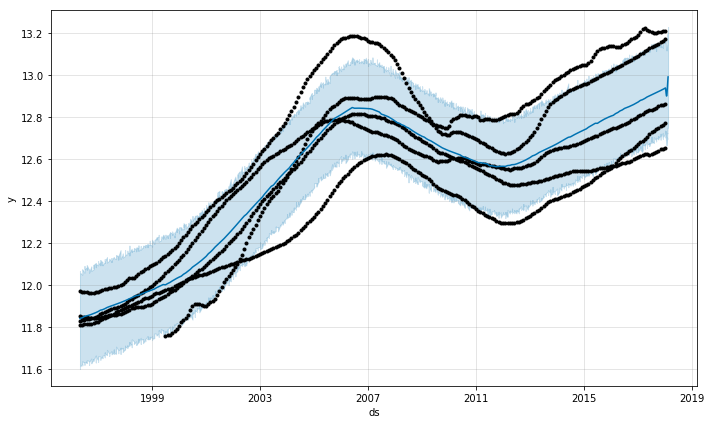

In [140]:
m.plot(forecast);

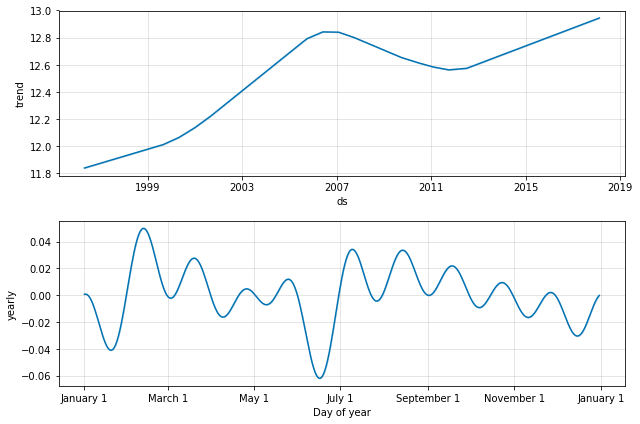

In [141]:
m.plot_components(forecast);

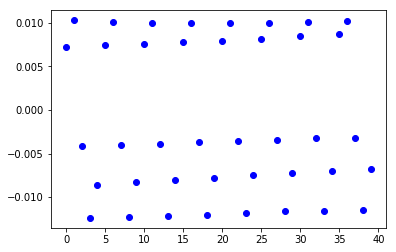

In [69]:
test=StateDF[len(StateDF)-40:]
test_df = pd.DataFrame(data = test)
y_truth = test_df.values
y_truth_df = pd.DataFrame(data = y_truth)
y_truth_df.columns = ['Date', 'y']
y_truth_df = y_truth_df.drop('Date', axis = 1)
y_forecasted = forecast.iloc[-40:,2].values
y_forecasted_df = pd.DataFrame(data = y_forecasted)
y_forecasted_df.columns = ['y']

y_t = y_truth_df['y'].tolist()
y_p = y_forecasted_df['y'].tolist()

deno = (np.abs(y_t) + np.abs(y_p))
diff = (np.abs(y_t) - np.abs(y_p)) / deno
diff[deno == 0] = 0.0
plt.plot(diff, 'bo')
plt.show()

In [112]:
#Load the data
neighbor_time_series=pd.read_csv("neighbor.csv",parse_dates=True)
neighbor_time_series.Date=pd.to_datetime(neighbor_time_series.Date)
neighbor_time_series['year'] = neighbor_time_series.Date.dt.year

neighbor_time_series.head()

Date  RegionName  InventorySeasonallyAdjusted_AllHomes  \
0 1996-04-30       10007                                   NaN   
1 1996-04-30       10329                                   NaN   
2 1996-04-30      104898                                   NaN   
3 1996-04-30      105745                                   NaN   
4 1996-04-30      105758                                   NaN   

   InventoryRaw_AllHomes  MedianListingPricePerSqft_1Bedroom  \
0                    NaN                                 NaN   
1                    NaN                                 NaN   
2                    NaN                                 NaN   
3                    NaN                                 NaN   
4                    NaN                                 NaN   

   MedianListingPricePerSqft_2Bedroom  MedianListingPricePerSqft_3Bedroom  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

   MedianListingPricePerSqft_4Bedroom  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

   MedianListingPricePerSqft_5BedroomOrMore  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   MedianListingPricePerSqft_AllHomes  ...   ZHVI_CondoCoop  ZHVI_MiddleTier  \
0                                 NaN  ...              NaN              NaN   
1                                 NaN  ...              NaN              NaN   
2                                 NaN  ...              NaN          72500.0   
3                                 NaN  ...              NaN          43200.0   
4                                 NaN  ...              NaN              NaN   

   ZHVI_SingleFamilyResidence  ZHVI_TopTier  ZRI_AllHomes  \
0                         NaN      147300.0           NaN   
1                         NaN           NaN           NaN   
2                     72500.0      106200.0           NaN   
3                     43200.0       49800.0           NaN   
4                         NaN       45600.0           NaN   

   ZRI_AllHomesPlusMultifamily  ZriPerSqft_AllHomes  \
0                          NaN                  NaN   
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   

   Zri_MultiFamilyResidenceRental  Zri_SingleFamilyResidenceRental  year  
0                             NaN                              NaN  1996  
1                             NaN                              NaN  1996  
2                             NaN                              NaN  1996  
3                             NaN                              NaN  1996  
4                             NaN                              NaN  1996  

[5 rows x 77 columns]

In [123]:
State_time_series['RegionName'] = pd.Categorical(State_time_series['RegionName'])

In [124]:
X = State_time_series[['Date', 'RegionName', 'ZHVI_MiddleTier', 'ZHVI_SingleFamilyResidence', 'ZHVI_TopTier']]
X.dropna(inplace=True)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [125]:
X['RegionName'] = (State_time_series['RegionName']).cat.codes
X.head()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Date  RegionName  ZHVI_MiddleTier  ZHVI_SingleFamilyResidence  \
0 1996-04-30           0          79500.0                     79000.0   
1 1996-04-30           2         103600.0                    107500.0   
2 1996-04-30           3          64400.0                     64500.0   
3 1996-04-30           4         157900.0                    162000.0   
4 1996-04-30           5         128100.0                    133600.0   

   ZHVI_TopTier  
0      140200.0  
1      168700.0  
2      115200.0  
3      270600.0  
4      209300.0

In [127]:
train_data = X.drop('RegionName', axis = 1)
train_data = X.drop('Date', axis = 1)
train_target = X['RegionName']

rfc = RandomForestClassifier(n_estimators = 6, n_jobs = -1)
scores_rfc = cross_val_score(rfc, train_data, train_target, cv = 10)

print('Mean Cross Validation Accuracy for Random Forest: {}'.format(scores_rfc.mean()))

Mean Cross Validation Accuracy for Random Forest: 0.8364602515365525


In [129]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, random_state=42)

rfc_fit = RandomForestClassifier(n_estimators = 10, n_jobs = -1).fit(X_train, y_train)
rfc_pred = rfc_fit.predict(X_test)

In [130]:
print(metrics.classification_report(rfc_pred, y_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        73
          1       1.00      1.00      1.00        69
          2       1.00      1.00      1.00        61
          3       1.00      1.00      1.00        67
          4       1.00      1.00      1.00        54
          5       1.00      1.00      1.00        66
          6       1.00      1.00      1.00        54
          7       1.00      1.00      1.00        69
          8       1.00      1.00      1.00        59
          9       1.00      1.00      1.00        52
         10       1.00      1.00      1.00        67
         11       1.00      1.00      1.00        60
         12       1.00      1.00      1.00        66
         13       1.00      1.00      1.00        70
         14       1.00      1.00      1.00        60
         15       1.00      1.00      1.00        70
         17       1.00      1.00      1.00        64
         19       1.00      1.00      1.00   

Text(91.68,0.5,'predicted label')

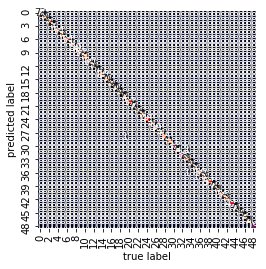

In [131]:
mat = confusion_matrix(rfc_pred, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [148]:
neighbor_time_series['RegionName'] = pd.Categorical(neighbor_time_series['RegionName'])
X = neighbor_time_series[['Date', 'RegionName', 'ZHVI_MiddleTier', 'ZHVI_SingleFamilyResidence', 'ZHVI_TopTier']]
X.dropna(inplace=True)
X['RegionName'] = (neighbor_time_series['RegionName']).cat.codes

train_data = X.drop('RegionName', axis = 1)
train_data = X.drop('Date', axis = 1)
train_target = X['RegionName']

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, random_state=42)

dt = GaussianNB().fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
score_dt = accuracy_score(y_pred_dt, y_test)
print('Accuracy for Decision Tree: {}'.format(score_dt))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Accuracy for Decision Tree: 0.0
